# Self-Driving Car Engineer Nanodegree


## Project: Build a Traffic Sign Recognition Classifier


## Imports

In [2]:
import matplotlib.image as mpimg
import pickle # Load pickled data
import pdb; # debugging
import numpy as np
import random 
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from sklearn.utils import shuffle
from tensorflow.contrib.layers import flatten
import cv2
import math
from sklearn import preprocessing
import statistics
from imgaug import augmenters as iaa
import os
from skimage.color import rgb2gray
# Visualizations will be shown in the notebook.
%matplotlib inline

## Helper Functions

In [ ]:
# images: array of images
# title: Title of hte figure
# num_disply: 0 means all of them
def show_image(images, title="",num_display=False,gray= False):
    image_len = num_display or len(images)
    fig = plt.figure(figsize=(image_len*2, image_len*2))
    random_index = random.sample(range(0, len(images)), image_len)

    for i in range(image_len):
        sub = fig.add_subplot(math.ceil(image_len/2), math.ceil(image_len/2), i + 1)
        sub.set_title(title)
        if gray:
            sub.imshow(images[random_index[i]].reshape(32,32),cmap='gray')
        else:
            sub.imshow(images[random_index[i]])
    
    return 0      

---
## Step 0: Load The Data

In [4]:
# Fill this in based on where you saved the training and testing data
training_file = "./traffic-signs-data/train.p"
validation_file="./traffic-signs-data/valid.p"
testing_file = "./traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

X_train_original, y_train_original = train['features'], train['labels']
X_valid_original, y_valid_original = valid['features'], valid['labels']
X_test_original, y_test_original   = test['features'], test['labels']

print("Data Loaded.")

Data Loaded.


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**
 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [ ]:
# Number of training examples
n_train = len(X_train_original)

# Number of validation examples
n_validation = X_valid_original.shape[0] # has num of example

# Number of testing examples.
n_test =  len(X_test_original)

# What's the shape of an traffic sign image?
image_shape = X_train_original.shape[1:]

# How many unique classes/labels there are in the dataset.
## since the labels are the same for training validation and test, I choose validation data because it has less data
n_classes = len(np.unique(y_valid_original))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Total examples =", n_test + n_validation + n_train )
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

### Organized images based on their labels

In [5]:
count_of_each_sign =  pd.Series.value_counts(train['labels'])

# organized train data by each labels
def organizing_train_data():
    output = {}
    indices = {}
    
    for key,value in count_of_each_sign.iteritems():
        indices[key] = [i for i, x in enumerate(train['labels']) if x == key]
        output[key] = {'features': train['features'][indices[key]], 
                       'sizes': train['sizes'][indices[key]],
                       'length': len(indices[key]),
                       '!augment': train['features'][indices[key]], # to be used later
                       'augment': np.empty(shape=(0, 32, 32, 3)) # to be used later
                      }
    
    # check data is correct organized
    for key , value in output.items():
        image = value['features']
        assert(len(image) == len(value['sizes']))
        assert(len(image) == value['length'])
        for i in range(len(image)):
            assert(np.array_equal(image[i], train['features'][indices[key][i]]) )
            assert(np.array_equal( value['sizes'][i], train['sizes'][indices[key][i]]))

    
    return output

######## call the function
organized_train_data = organizing_train_data()
print("data organized")

data organized


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.


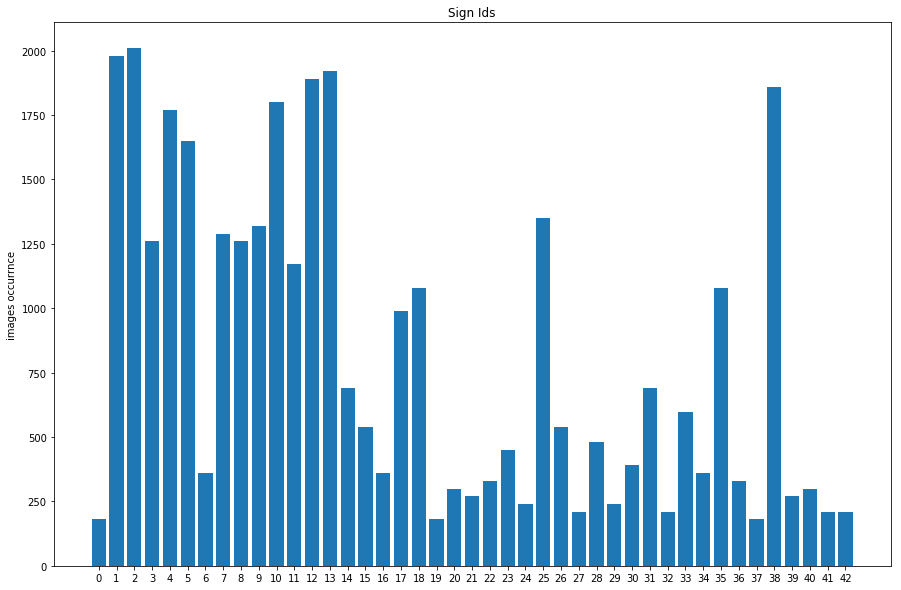

In [17]:
map_sign = pd.DataFrame.from_csv(path="./signnames.csv")['SignName']

f, axs = plt.subplots(1,1,figsize=(15,10))
axs.bar(height=count_of_each_sign.values, left=count_of_each_sign.keys() , width=.8,bottom=0,align='center')
plt.ylabel('images occurrnce')
plt.title('Sign Ids')
plt.xticks(np.arange(0, n_classes, 2))
plt.show()

In [ ]:
#  visualize an image from each class
images = []
titles = []
for key,value in count_of_each_sign.iteritems():
    images.append(random.choice(organized_train_data[key]['features']))
    titles.append( map_sign[key] + ", # occurrence: " + str(value) )


fig, ax = plt.subplots(nrows=22, ncols=2,figsize=(15, 80))
i = 0
for row in ax:
    for col in row:
        col.set_title(titles[i],fontsize=12)
        col.imshow(images[i])
        i += 1
        if (i == len(images)):
            break


## Augmentation data

### Augmentation algorithem

In [ ]:
# using the following library http://imgaug.readthedocs.io/en/latest/index.html
def augment_data(images):
    output = iaa.SomeOf(1,[
        iaa.Affine(rotate=(-45, 45)),
        iaa.CropAndPad(percent=(-0.25, 0.25)),
        iaa.Dropout(p=(0, 0.25)),
        iaa.Sequential([
            iaa.ChangeColorspace(from_colorspace="RGB", to_colorspace="HSV"),
            iaa.WithChannels(0, iaa.Add((50, 100))),
            iaa.ChangeColorspace(from_colorspace="HSV", to_colorspace="RGB"),
            iaa.Dropout(p=(0, 0.15))
        ])
    ])  
        
    return  output.augment_images(images)

index = random.randint(0, n_train)

image = train["features"][index:index+1]
show_image(image,"Original")
show_image(augment_data(image),"Augment 1")
show_image(augment_data(image),"Augment 2")

### Augmentation Helepr Functions

In [ ]:
# check each image label if it eligible to augment
# this method uses the mean of the occurrence of images for each label.
def  lebel_eligible_to_augment(image_occurrence_in_train,mean_of_occurrence_of_signs):
    
    # to maintain the varince 
    if mean_of_occurrence_of_signs - (image_occurrence_in_train * 1.05) > 1:
         return True
        
    return False 

# check original image size if grather than 32 width and height then the image is eligible
def images_eligible_to_augment(images,sizes):
    output = {'features':[],'sizes': []}
    for i in range(len(images)):
        # width and hight
        if sizes[i][0] >32 and sizes[i][1] >32:
            output['features'].append(images[i])
            output['sizes'].append(sizes[i])
    
    return output

### Apply Augmentation

In [ ]:
# run the training data 
def aug_train_data(organized_train_data,mean_of_occurrence_of_signs):
    output = {}
    for key, value in organized_train_data.items():
        not_augment_images = value['!augment']   # only select images that were not augmented
        sizes = value['sizes']
        img_len = len(value['features'])
        
        if lebel_eligible_to_augment(img_len, mean_of_occurrence_of_signs):
            # obtain images that should be augmented
            eligible_data = images_eligible_to_augment(not_augment_images,sizes)
            
            aug_images = augment_data(eligible_data['features'])
            
            output[key] = {'features':np.concatenate((value['features'] , aug_images)),
                           'augment': aug_images,
                           '!augment':not_augment_images,
                           'sizes': np.concatenate((sizes , eligible_data['sizes'])),
                           'length': img_len + len(aug_images)
                          }
        else:
             output[key] = {'features':value['features'],
                           'augment': np.empty(shape=(0, 32, 32, 3)),
                           '!augment':not_augment_images,
                           'sizes': sizes,
                           'length': img_len
                          }
    
    
    return output

# convert data fromat to match the original dataset
def prepare_data(organized_train_data):
    output = {'features' : np.empty(shape=(0, 32, 32, 3)),
              'labels': np.empty(shape=(0,)),
              'sizes': np.empty(shape=(0,2))
             }
    
    for key, value in organized_train_data.items():
        images = value['features']
        sizes = value['sizes']                                         
        img_len = len(images)
        output['features'] = np.concatenate((output['features'] , images))
        output['labels']   = np.concatenate((output['labels']   , [key]*img_len ))
        output['sizes']    = np.concatenate((output['sizes']    , sizes ))

        
    return output

In [ ]:
# run augmentation multiple times
def smart_augmentation(train_data,num_of_iter=2):
    output = train_data
    
    for i in range(num_of_iter):
        mean_of_occurrence_of_signs = statistics.mean([value['length'] for key,value in output.items()])
        
        output = aug_train_data(output,mean_of_occurrence_of_signs)
    
    # convert the dataset to have the same format as the original dataset
    return prepare_data(output)      
    
# call the function  
num_of_iter = 17
a_train = smart_augmentation(organized_train_data,num_of_iter)
aug_count_of_each_sign =  pd.Series.value_counts(a_train["labels"])

### New Date Info

In [ ]:
print("Number of old training examples =", train['features'].shape[0])
print("Number of new training examples =", a_train['features'].shape[0])
print("Image data shape =", a_train['features'].shape)
print("old mean =", statistics.mean(count_of_each_sign))
print("new mean =",statistics.mean(aug_count_of_each_sign))
print("old variance =", statistics.variance(count_of_each_sign))
print("new variance =", statistics.variance(aug_count_of_each_sign))

print("#########################  number of each sign occurrence #########################" )
for key,value in aug_count_of_each_sign.iteritems():
    print( str(key) + "\t occurrence =" + str(value) + "\t" +  map_sign[key] )

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

###  Normalization

In [ ]:
def normlization(imgs):
    return (imgs - 128)/128

###  RGB To Gray

In [ ]:
def rgb_to_gray(imgs):
    imgs = rgb2gray(imgs)
    imgs = imgs.reshape(imgs.shape + (1,))
    return  imgs

### Apply Pre Process

In [ ]:
def apply_pre_process(images):
    
    output = normlization(images)
    output = rgb_to_gray(output)
    return output

# apply_pre_process
y_train_pre_process = a_train["labels"]
x_train_pre_process = apply_pre_process(a_train["features"])
X_valid_pre_process = apply_pre_process(X_valid_original)

print("data pre-process")

In [ ]:
# # Shuffle the training data.
# to make sure
x_train_ready, y_train_ready = shuffle(x_train_pre_process, y_train_pre_process)
x_train_ready, y_train_ready = shuffle(x_train_ready, y_train_ready)
x_train_ready, y_train_ready = shuffle(x_train_ready, y_train_ready)

print('data shuffle')


### Model Architecture

In [ ]:
### Define your architecture here.

# Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
mu = 0
sigma = 0.1
# Using the default mean and standard deviation from tf.truncated_normal() is fine. 
# However, tuning these hyperparameters can result in better performance.
weights = {
    'wc1': tf.Variable(tf.truncated_normal([5, 5, 1, 6], mean = mu, stddev = sigma),name='wc1'),
    'wc2': tf.Variable(tf.truncated_normal([5, 5, 6, 16], mean = mu, stddev = sigma),name='wc2'),
    'wd1': tf.Variable(tf.truncated_normal([400,120], mean = mu, stddev = sigma),name='wd1'),
    'wd2': tf.Variable(tf.truncated_normal([120,84], mean = mu, stddev = sigma),name='wd2'),
    'out': tf.Variable(tf.truncated_normal([84,43], mean = mu, stddev = sigma),name='w_out')
}
biases = {
    'bc1': tf.Variable(tf.zeros(6),name='bc1'),
    'bc2': tf.Variable(tf.zeros(16),name='bc2'),
    'bd1': tf.Variable(tf.zeros(120),name='bd1'),
    'bd2': tf.Variable(tf.zeros(84),name='bd2'),
    'out': tf.Variable(tf.zeros(43),name='b_out')
}
def LeNet(x): 
    dropout = .5 # since there is no a lot of data
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    x = tf.nn.conv2d(x, weights['wc1'], strides=[1, 1, 1, 1], padding='VALID')
    x = tf.nn.bias_add(x, biases['bc1'])
    #  Activation.
    x = tf.nn.relu(x)
    #  Pooling. Input = 28x28x6. Output = 14x14x6.
    x = tf.nn.max_pool(
        x,
        ksize=[1, 2, 2, 1],
        strides=[1, 2,2, 1],
        padding='VALID')
    #  Layer 2: Convolutional. Output = 10x10x16.
    x = tf.nn.conv2d(x, weights['wc2'], strides=[1, 1, 1, 1], padding='VALID')
    x = tf.nn.bias_add(x, biases['bc2'])
    # Activation.
    x = tf.nn.relu(x)
    # Pooling. Input = 10x10x16. Output = 5x5x16.
    x = tf.nn.max_pool(
        x,
        ksize=[1, 2, 2, 1],
        strides=[1, 2,2, 1],
        padding='VALID')
    # Flatten. Input = 5x5x16. Output = 400.
    x = tf.contrib.layers.flatten(x)
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    x = tf.add(tf.matmul(x, weights['wd1']), biases['bd1'])
    #  Activation.
    x = tf.nn.relu(x)
    #  Layer 4: Fully Connected. Input = 120. Output = 84.
    x = tf.add(tf.matmul(x, weights['wd2']), biases['bd2'])
    #  Activation.
    x = tf.nn.relu(x)
    x = tf.nn.dropout(x, dropout)
    #  Layer 5: Fully Connected. Input = 84. Output = 43.
    logits = tf.add(tf.matmul(x, weights['out']), biases['out'])
    return logits

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [ ]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.
x = tf.placeholder(tf.float32, (None, 32, 32, 1),name="x_placeholder")
y = tf.placeholder(tf.int32, (None),name="y_placeholder")
one_hot_y = tf.one_hot(y, 43)

rate = 0.001

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [ ]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()
BATCH_SIZE = 128
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [ ]:
EPOCHS = 75
y_accuracy_label = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = x_train_ready.shape[0]
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        x_train_ready, y_train_ready = shuffle(x_train_ready, y_train_ready)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = x_train_ready[offset:end], y_train_ready[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
           
        validation_accuracy = evaluate(X_valid_pre_process, y_valid_original)
        y_accuracy_label.append(validation_accuracy)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")


In [ ]:
x_epoch_label = [i + 1 for i in range(0,EPOCHS)]
plt.plot(x_epoch_label,1 - np.array(y_accuracy_label))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Cost')
plt.show()

In [ ]:
X_test = apply_pre_process(X_test_original)
print(X_test.shape)
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    test_accuracy = evaluate(X_test, y_test_original)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
# taken from https://en.wikipedia.org/wiki/Road_signs_in_Germany
dirname = "test_images/"
test_images_path =   [s for s in os.listdir(dirname) if s.endswith('.png')]
y_images = []
x_images = []
for img_path in test_images_path:
    img = mpimg.imread(dirname + img_path)
    # convert from 4 channel to 3
    img = cv2.cvtColor(img,cv2.COLOR_RGBA2RGB)
    width = img.shape[0]
    height = img.shape[1]
    if (width or height) < 32:
        pad_width = int(( 32 - width) / 2)
        pad_height = int((32 - height) /2)
        # Pad images with 0s
        img = np.pad(img, ((pad_width,pad_width),(pad_height,pad_height),(0,0)), 'constant')
    
    x_images.append(img)
    y_images.append(int(img_path.split('_')[0]))
# convert dateset to numpy array
x_images = np.array(x_images)
y_images = np.array(y_images)
show_image(x_images)

### Predict the Sign Type for Each Image

In [ ]:
### Run the predictions here and use the model to output the prediction for each image.
x_images_ready = apply_pre_process(x_images)
softmax_probabilities = {}
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    new_images_test_accuracy = evaluate(x_images_ready, y_images)
    for img,label in zip(x_images_ready,y_images):
        accuracy = sess.run(tf.argmax(logits, 1), feed_dict={x: [img]})
        softmax_probabilities[label]= sess.run(tf.nn.top_k(logits,k=5), feed_dict={x: [img]})
        show_image([img],title=map_sign[accuracy[0]],gray=True)


### Analyze Performance

In [ ]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.
print("Test Accuracy = {:.3f}".format(new_images_test_accuracy))

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [ ]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
for key, p in softmax_probabilities.items():
    print("==================== " + str(map_sign[int(key)]) + " ====================")
    print()
    for value,index in zip(p.values[0],p.indices[0]):
        print(str(int(value*100)) + "%\t" + map_sign[index]  )
    
    print()
    print()

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    image_input = apply_pre_process(image_input)
    
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    with tf.Session() as sess:
        saver.restore(sess, tf.train.latest_checkpoint('.'))
        activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")
            


tf_activation =  tf.nn.conv2d(x, weights['wc1'], strides=[1, 1, 1, 1], padding='VALID')
outputFeatureMap(x_images,tf_activation)
